# Лабораторная работа №6: Исследование моделей классификации

## Импорт библиотек

In [20]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import os

## Выбор набора данных

Датасет: Подмножество Oxford-IIIT Pet Dataset (5 классов)

Обоснование: Распознавание пород животных полезно для ветеринарных приложений и автоматизации работы приютов.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50910366..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30636168..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.6073294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


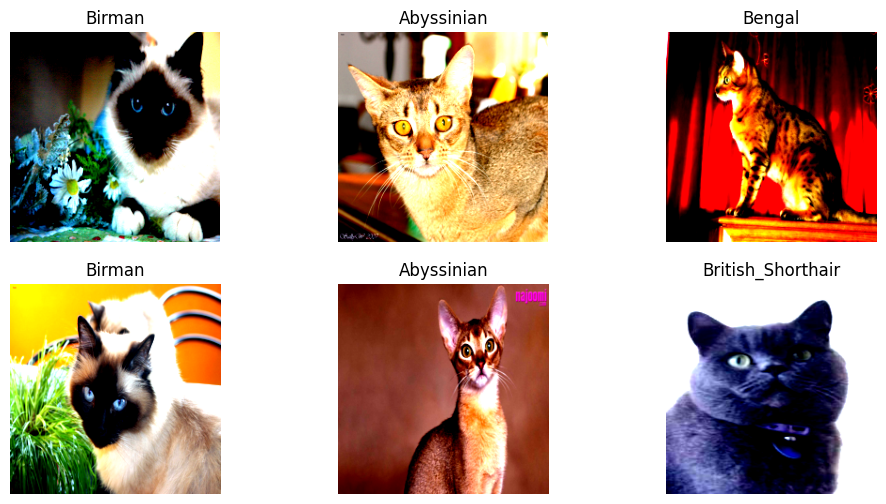

In [22]:
# Настройки
torch.manual_seed(42)
DATA_DIR = 'C:\\Users\\Ekaterina\\Downloads\\images\\images\\'
SELECTED_BREEDS = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']
IMG_SIZE = 224
BATCH_SIZE = 32

# %%
# Трансформации данных
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize
])

# Загрузка и фильтрация датасета
full_dataset = datasets.ImageFolder(DATA_DIR)
indices = [i for i, (path, label) in enumerate(full_dataset.samples) 
           if full_dataset.classes[label] in SELECTED_BREEDS]

# Разделение данных
train_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=[full_dataset.targets[i] for i in indices]
)

# Создание Dataset и DataLoader
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

train_dataset.dataset.transform = base_transform
test_dataset.dataset.transform = base_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Визуализация данных
images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(full_dataset.classes[labels[i].item()])
    plt.axis('off')
plt.show()

## Бейзлайн: обучение моделей

Модели: ResNet-18 (CNN) и ViT-B/16 (трансформер)

Метрики: Accuracy (основная), F1-score (дополнительная)

In [23]:
# Инициализация моделей
def init_model(model_name):
    if model_name == 'resnet':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 5)
    elif model_name == 'vit':
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(model.heads.head.in_features, 5)
        model.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    return model

In [25]:
# Функция обучения
def train_eval_model(model, epochs=5, lr=0.001):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_acc': []}
    
    print(f"\nTraining {model.__class__.__name__}...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')
        print('-'*50)
    
    return history

In [26]:
# %%
# Обучение ResNet-18
resnet = init_model('resnet')
resnet_history = train_eval_model(resnet, epochs=5)


Training ResNet...
Epoch 1/5
Train Loss: 0.5974 | Val Acc: 0.6050
--------------------------------------------------
Epoch 2/5
Train Loss: 0.2610 | Val Acc: 0.8350
--------------------------------------------------
Epoch 3/5
Train Loss: 0.1452 | Val Acc: 0.8600
--------------------------------------------------
Epoch 4/5
Train Loss: 0.1014 | Val Acc: 0.8850
--------------------------------------------------
Epoch 5/5
Train Loss: 0.0856 | Val Acc: 0.8200
--------------------------------------------------


In [27]:
# %%
# Обучение ViT-B/16
vit = init_model('vit')
vit_history = train_eval_model(vit, epochs=5)


Training VisionTransformer...
Epoch 1/5
Train Loss: 1.8273 | Val Acc: 0.1900
--------------------------------------------------
Epoch 2/5
Train Loss: 1.6418 | Val Acc: 0.2250
--------------------------------------------------
Epoch 3/5
Train Loss: 1.6175 | Val Acc: 0.1850
--------------------------------------------------
Epoch 4/5
Train Loss: 1.6626 | Val Acc: 0.2350
--------------------------------------------------
Epoch 5/5
Train Loss: 1.6512 | Val Acc: 0.2450
--------------------------------------------------


### Визуализация обучения

Результаты: 

1. ResNet-18: Train Loss: 0.0856 | Val Acc: 0.8200

2. ViT-B/16: Train Loss: 1.6512 | Val Acc: 0.2450

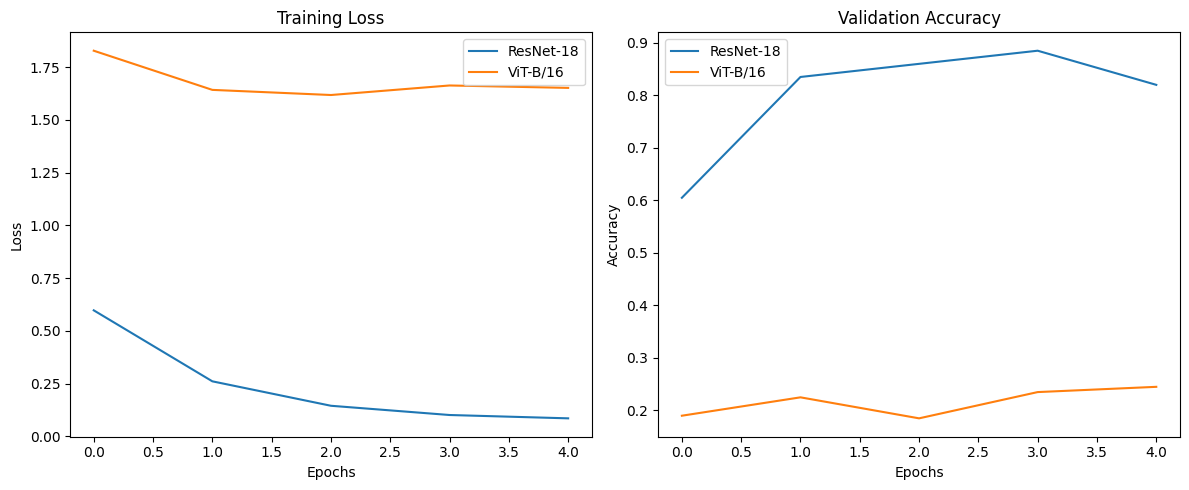

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history['train_loss'], label='ResNet-18')
plt.plot(vit_history['train_loss'], label='ViT-B/16')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history['val_acc'], label='ResNet-18')
plt.plot(vit_history['val_acc'], label='ViT-B/16')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Обучение ViT-B/16 реализовать далее не удалось, так как характеристики устройства не позволяют этого сделать

## Улучшение бейзлайна

In [33]:
# Правильная заморозка слоев ResNet
resnet_improved = models.resnet18(pretrained=True)

# Замораживаем все слои, кроме последнего
for param in resnet_improved.parameters():
    param.requires_grad = False
    
# Заменяем последний слой (он будет обучаться)
num_features = resnet_improved.fc.in_features
resnet_improved.fc = nn.Linear(num_features, 5)
resnet_improved.fc.requires_grad = True  # Это лишнее, так как новый слой по умолчанию требует градиент

# Проверка какие параметры будут обучаться
print("Обучаемые параметры:")
for name, param in resnet_improved.named_parameters():
    if param.requires_grad:
        print(name)

Обучаемые параметры:
fc.weight
fc.bias


In [34]:
# Аугментации для улучшенной модели
train_transform_improved = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalize
])

# Применяем новые трансформации
train_dataset.dataset.transform = train_transform_improved

In [35]:
# Обучение улучшенной модели
optimizer_improved = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, resnet_improved.parameters()),
    lr=1e-4,
    weight_decay=0.01
)

criterion = nn.CrossEntropyLoss()

improved_history = {'train_loss': [], 'val_acc': []}

print("\nTraining Improved ResNet-18...")
for epoch in range(10):
    resnet_improved.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer_improved.zero_grad()
        outputs = resnet_improved(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_improved.step()
        running_loss += loss.item()
    
    # Валидация
    resnet_improved.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = resnet_improved(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    improved_history['train_loss'].append(epoch_loss)
    improved_history['val_acc'].append(epoch_acc)
    
    print(f'Epoch {epoch+1}/10')
    print(f'Train Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')
    print('-'*50)




Training Improved ResNet-18...
Epoch 1/10
Train Loss: 1.6240 | Val Acc: 0.3450
--------------------------------------------------
Epoch 2/10
Train Loss: 1.4532 | Val Acc: 0.4850
--------------------------------------------------
Epoch 3/10
Train Loss: 1.3367 | Val Acc: 0.6150
--------------------------------------------------
Epoch 4/10
Train Loss: 1.2233 | Val Acc: 0.7050
--------------------------------------------------
Epoch 5/10
Train Loss: 1.1397 | Val Acc: 0.7550
--------------------------------------------------
Epoch 6/10
Train Loss: 1.0377 | Val Acc: 0.8100
--------------------------------------------------
Epoch 7/10
Train Loss: 0.9680 | Val Acc: 0.8250
--------------------------------------------------
Epoch 8/10
Train Loss: 0.8949 | Val Acc: 0.8250
--------------------------------------------------
Epoch 9/10
Train Loss: 0.8285 | Val Acc: 0.8800
--------------------------------------------------
Epoch 10/10
Train Loss: 0.7823 | Val Acc: 0.8650
----------------------------

### Визуализация обучения

Результаты: 

1. ResNet-18: Train Loss: 0.7823 | Val Acc: 0.8650

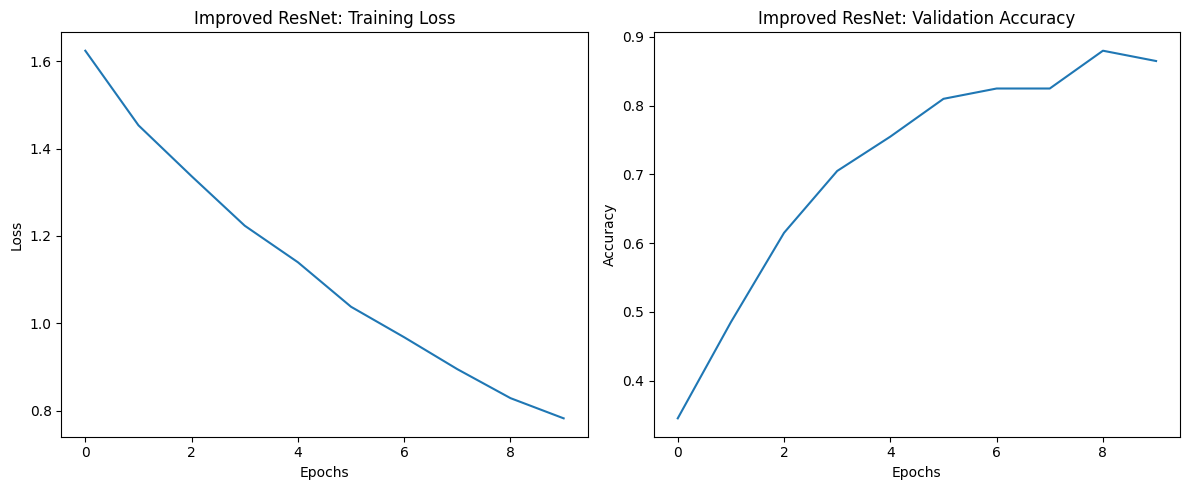

In [36]:
# Визуализация улучшенной модели
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(improved_history['train_loss'])
plt.title('Improved ResNet: Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(improved_history['val_acc'])
plt.title('Improved ResNet: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Кастомная модель

Архитектура CNN

In [37]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*(IMG_SIZE//4)**2, 256),
            nn.ReLU(),
            nn.Linear(256, 5)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [39]:
# Обучение кастомной модели
custom_model = SimpleCNN()
custom_history = train_eval_model(custom_model, epochs=25, lr=0.0005)


Training SimpleCNN...
Epoch 1/25
Train Loss: 2.7384 | Val Acc: 0.3700
--------------------------------------------------
Epoch 2/25
Train Loss: 1.2831 | Val Acc: 0.4500
--------------------------------------------------
Epoch 3/25
Train Loss: 1.0459 | Val Acc: 0.5250
--------------------------------------------------
Epoch 4/25
Train Loss: 0.9374 | Val Acc: 0.5450
--------------------------------------------------
Epoch 5/25
Train Loss: 0.8573 | Val Acc: 0.5700
--------------------------------------------------
Epoch 6/25
Train Loss: 0.8214 | Val Acc: 0.6100
--------------------------------------------------
Epoch 7/25
Train Loss: 0.7594 | Val Acc: 0.5950
--------------------------------------------------
Epoch 8/25
Train Loss: 0.6940 | Val Acc: 0.5700
--------------------------------------------------
Epoch 9/25
Train Loss: 0.6593 | Val Acc: 0.6450
--------------------------------------------------
Epoch 10/25
Train Loss: 0.6456 | Val Acc: 0.6250
-------------------------------------

Результаты: 

1. Train Loss: 0.2479 | Val Acc: 0.6500

## Финальное сравнение моделей

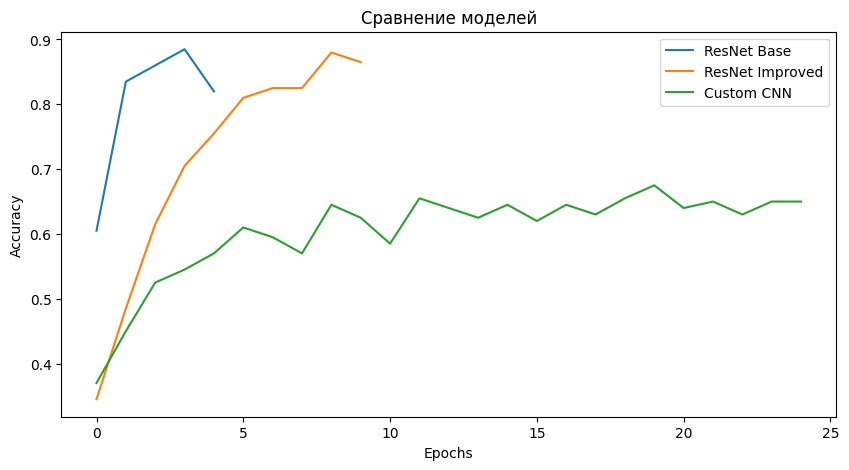

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_history['val_acc'], label='ResNet Base')
plt.plot(improved_history['val_acc'], label='ResNet Improved')
plt.plot(custom_history['val_acc'], label='Custom CNN')
plt.title('Сравнение моделей')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()